# Logistic Regression

Goals of this notebook: 
- Test the performance of a logistic regression model in classifying if a loan was paid off or not
- Use a grid search algorithm to determine an optimal regularization value for the model

In [6]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

#### Load the data, normalize, and split into a training and validation set

In [7]:
def min_max_data_normalize(data_train, data_test):
    data_min = data_train.min()
    data_max = data_train.max()
    normal_data_train = (data_train - data_min) / (data_max - data_min)
    normal_data_test = (data_test - data_min) / (data_max - data_min)
    
    return normal_data_train, normal_data_test

def data_processed():
    '''
    Used to read & normalize processed test and train data
    '''
    data_train = pd.read_csv("data/2022-02-06_LOANS_TRAIN.csv")
    data_test = pd.read_csv("data/2022-02-06_LOANS_TEST.csv")
    y_train = data_train['loan_status']
    data_train.drop('loan_status', 1, inplace=True)
    normal_data_train, normal_data_test = min_max_data_normalize(data_train, data_test)
    
    return normal_data_train, normal_data_test, y_train

def to_submission(y_test_predicted_probability):
    y_test = pd.DataFrame(y_test_predicted_probability, columns=['loan_status'])
    y_test.to_csv('data/submission.csv', index_label='id')
    return

In [8]:
X_train, X_test, y_train = data_processed()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42, shuffle=True)

print(f"""
X_train shape: {X_train.shape}
y_train shape: {y_train.shape}
X_val shape: {X_val.shape}
y_val shape: {y_val.shape}
""")

/var/folders/h7/dxctt03x2vjdfbhcmgymr3400000gn/T/ipykernel_11626/493885001.py:16: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_train.drop('loan_status', 1, inplace=True)



X_train shape: (132157, 29)
y_train shape: (132157,)
X_val shape: (65093, 29)
y_val shape: (65093,)



#### Train a logistic regression model using the default parameters

In [5]:
logistic = LogisticRegression(max_iter=400) 

# Fit the logistic regression model to the data
logistic.fit(X_train, y_train)   

LogisticRegression(max_iter=400)

In [6]:
logistic.score(X_val, y_val)

0.8464811884534436

In [7]:
# convert to one-hot encoding
y_val_oh = to_categorical(y_val)

In [8]:
y_pred = logistic.predict_proba(X_val)
roc_auc_score(y_val_oh, y_pred)

0.6785396237311278

In [9]:
prediction = logistic.predict(X_val)

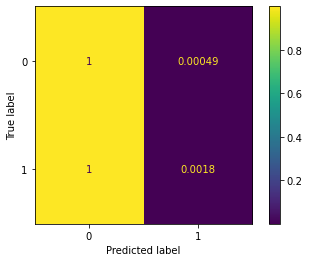

In [16]:
conf = confusion_matrix(y_val, prediction, normalize='true')
disp = ConfusionMatrixDisplay(conf)
disp.plot()

Note: I initially got a convergence error, so I increased the maximum number of iterations.

#### Use the grid search algorithm to determine the best regularization parameter
I'll use 10-fold cross validation. I'll use the default scoring metric for now, then see if the performance is comparable when using the roc_auc_score. I also am only looking at different regularization values - other parameters can potentially be tuned, but I won't worry about it for now.

~ Note: The following cell takes a long time to run!

In [40]:
logistic = LogisticRegression(max_iter=1000) 
parameters = {'C':[0.001, 0.1, 1, 10, 100]}

clf = GridSearchCV(logistic, parameters, cv=10)
clf.fit(X_train, y_train)  

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.001, 0.1, 1, 10, 100]})

In [41]:
pd.DataFrame(clf.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.378030,0.029960,0.003524,0.000953,0.001,{'C': 0.001},0.846852,0.846852,0.846852,0.846852,0.846852,0.846852,0.846852,0.846841,0.846841,0.846841,0.846849,0.000005,1
3,4.801042,0.629342,0.003430,0.001374,10,{'C': 10},0.846928,0.846701,0.846701,0.846777,0.846398,0.846928,0.847004,0.846614,0.846614,0.846614,0.846728,0.000175,2
4,5.308550,0.938221,0.003262,0.001067,100,{'C': 100},0.847004,0.846701,0.846701,0.846625,0.846474,0.846928,0.846928,0.846689,0.846538,0.846614,0.846720,0.000168,3
2,2.742473,0.463577,0.003051,0.000409,1,{'C': 1},0.846852,0.846777,0.846701,0.846701,0.846474,0.846777,0.846852,0.846614,0.846614,0.846538,0.846690,0.000122,4
1,1.760527,0.107468,0.003638,0.000992,0.1,{'C': 0.1},0.846701,0.846701,0.846625,0.846701,0.846474,0.846777,0.846625,0.846538,0.846614,0.846538,0.846629,0.000088,5


C = 0.001 performed best with 20-fold cross validation for the logistic regression.

#### Implement a logistic regression model with C=0.001 and evaluate with roc_auc_score

In [59]:
logistic = LogisticRegression(max_iter=400, C=0.001) 

# Fit the logistic regression model to the data
logistic.fit(X_train, y_train)   

y_pred = logistic.predict_proba(X_val)
y_val_oh = to_categorical(y_val)
roc_auc = roc_auc_score(y_val_oh, y_pred)
roc_auc

0.6691286962440637

#### Since there was not a significant difference in the accuracy of the different C values, I also implemented a logistic regression model with C=100

In [62]:
logistic = LogisticRegression(max_iter=1000, C=100) 

# Fit the logistic regression model to the data
logistic.fit(X_train, y_train)   

y_pred = logistic.predict_proba(X_val)
y_val_oh = to_categorical(y_val)
roc_auc = roc_auc_score(y_val_oh, y_pred)
roc_auc

0.6817261153565823

#### Implement PCA upstream of logistic regression

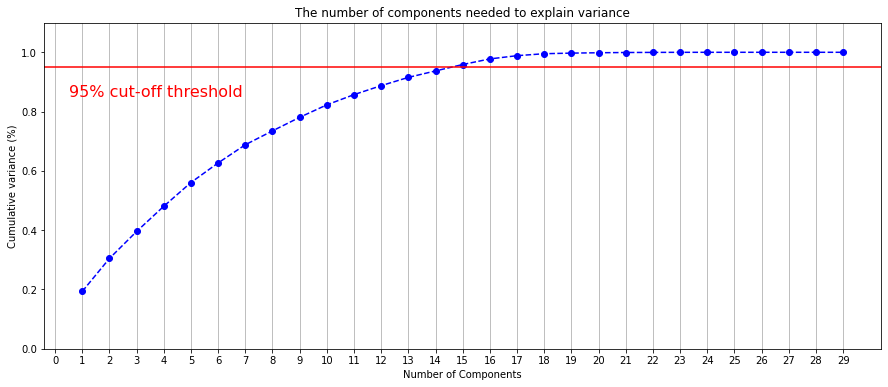

In [67]:
pca = PCA().fit(X_train)

plt.rcParams["figure.figsize"] = (15,6)

fig, ax = plt.subplots()
xi = np.arange(1, 30, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 30, step=1)) 
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [68]:
pca = PCA(n_components = 0.95)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_val = pca.transform(X_val)

In [69]:
logistic = LogisticRegression(max_iter=400, C=0.001) 

# Fit the logistic regression model to the data
logistic.fit(X_train, y_train)   

y_pred = logistic.predict_proba(X_val)
y_val_oh = to_categorical(y_val)
roc_auc = roc_auc_score(y_val_oh, y_pred)
roc_auc

0.6621991037517256

#### Try TomekLinks

In [1]:
from imblearn.under_sampling import TomekLinks

In [23]:
def over_under_sampling(X_train,Y_train,method,fraction):
    if method=="random":
        rus = RandomUnderSampler(random_state=0,sampling_strategy=fraction)
    elif method=="centroid":
        rus = ClusterCentroids(random_state=42,sampling_strategy=fraction)
    elif method=="SMOTENN":
        rus = SMOTEENN(random_state=42,sampling_strategy=fraction)
    elif method=="Tomek":
        rus = TomekLinks(sampling_strategy='majority')
    X_resampled, y_resampled = rus.fit_resample(X_train, Y_train)
    return X_resampled, y_resampled

In [ ]:
X_train, y_train = over_under_sampling(X_train, y_train, 'Tomek', 0)

In [ ]:
logistic = LogisticRegression(max_iter=400, C=0.001) 

# Fit the logistic regression model to the data
logistic.fit(X_train, y_train)   

y_pred = logistic.predict_proba(X_val)
y_val_oh = to_categorical(y_val)
roc_auc = roc_auc_score(y_val_oh, y_pred)
roc_auc

In [ ]:
prediction = logistic.predict(X_val)
conf = confusion_matrix(y_val, prediction, normalize='true')
disp = ConfusionMatrixDisplay(conf)
disp.plot();

In [20]:
confusion_matrix(y_val, prediction)

array([[55109,     0],
       [ 9984,     0]])

### Summary of findings

- Using a logistic regression model with l2 regularization achieved ~67% accuracy in classifying the loan data.
- The grid search algorithm was used to optimize the C regularization parameter, but this showed no significant improvement in performance 
- PCA was performed upstream of the logistic regression model, but also showed no significant improvement in performance
- The tomek method was used for undersampling, but did not help. It just exclusively predicted label 1 for all points.